In [12]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import pickle
from tensorflow.keras.applications.vgg19 import preprocess_input
import os
import time
from tensorflow.keras.models import load_model


In [2]:
model_dir = '..\models\decoder'
# load the model from the saved directory
decoder = tf.keras.models.load_model(model_dir)

model_dir = '..\models\encoder'
# load the model from the saved directory
encoder = tf.keras.models.load_model(model_dir)

In [3]:
#define our greedy method of defining captions:

def evaluate(image):
   attention_plot = np.zeros((max_length, attention_features_shape))
   hidden = tf.zeros((1, 512))
   temp_input = tf.expand_dims(load_image(image)[0], 0)
   img_tensor_val = image_features_extract_model(temp_input)
   img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))
   features = encoder(img_tensor_val)
   dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
   result = []

   for i in range(max_length):
       predictions, hidden, attention_weights = decoder(dec_input, features, hidden)
       attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()
       predicted_id = tf.argmax(predictions[0]).numpy()
       result.append(tokenizer.index_word[predicted_id])

       if tokenizer.index_word[predicted_id] == '<end>':
           return result, attention_plot

       dec_input = tf.expand_dims([predicted_id], 0)
   attention_plot = attention_plot[:len(result), :]

   return result, attention_plot

In [4]:
#define a function to plot the attention maps for each word generated

def plot_attention(image, result, attention_plot):
   temp_image = np.array(Image.open(image))
   fig = plt.figure(figsize=(10, 10))
   len_result = len(result)
   for l in range(len_result):
       temp_att = np.resize(attention_plot[l], (8, 8))
       ax = fig.add_subplot(len_result//2, len_result//2, l+1)
       ax.set_title(result[l])
       img = ax.imshow(temp_image)
       ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

   plt.tight_layout()
   plt.show()

generate a caption for the image

In [5]:
with open('img_name_val.pkl', 'rb') as f:
    img_name_val = pickle.load(f)
    
with open('cap_val.pkl', 'rb') as f:
    cap_val = pickle.load(f)
    
# Load the tokenizer from the file
with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)
    
# Load max_length from the saved file
with open('max_length.pkl', 'rb') as f:
    max_length = pickle.load(f)
    
attention_features_shape = 49


In [6]:
def load_image(image_path):
   img = tf.io.read_file(image_path)
   img = tf.image.decode_jpeg(img, channels=3)
   img = tf.image.resize(img, (224, 224))
   img = preprocess_input(img)
   return img, image_path


In [7]:
image_model = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output
image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

In [8]:
image_features_extract_model.save('image_features_extract_model.h5')

In [9]:

image_features_extract_model = load_model('image_features_extract_model.h5')


BELU score: 3.759340464156993
Real Caption: three men drink at reflective bar
Prediction Caption: five people stand in bar


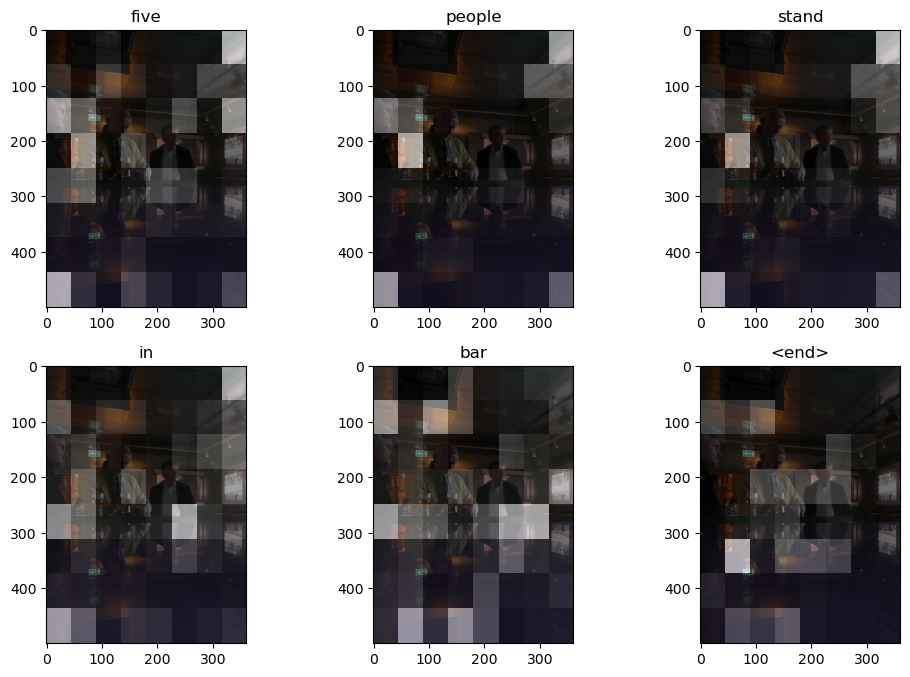

time took to Predict: 2 sec


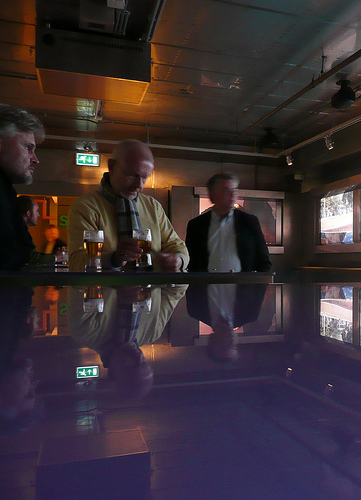

In [18]:
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
start = time.time()
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)

# remove <start> and <end> from the real_caption
first = real_caption.split(' ', 1)[1]
real_caption = first.rsplit(' ', 1)[0]

#remove "<unk>" in result
for i in result:
   if i=="<unk>":
       result.remove(i)

for i in real_caption:
   if i=="<unk>":
       real_caption.remove(i)

#remove <end> from result        
result_join = ' '.join(result)
result_final = result_join.rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = result
smoothie = SmoothingFunction().method4  # choose a smoothing function

# compute BLEU score
score = sentence_bleu(reference, candidate, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smoothie)
#score = sentence_bleu(reference, candidate)
print(f"BELU score: {score*100}")

print ('Real Caption:', real_caption)
print ('Prediction Caption:', result_final)

plot_attention(image, result, attention_plot)
print(f"time took to Predict: {round(time.time()-start)} sec")
Image.open(img_name_val[rid])